This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks).

# Parallelization

Behind the scenes, ELFI can automatically parallelize the computational inference via different clients. Currently ELFI includes three clients:

- `elfi.clients.native` (activated by default): does not parallelize but makes it easy to test and debug your code.
- `elfi.clients.multiprocessing`: basic local parallelization using Python's built-in multiprocessing library
- `elfi.clients.ipyparallel`: [ipyparallel](http://ipyparallel.readthedocs.io/) based client that can parallelize from multiple cores up to a distributed cluster.

A client is activated by importing the respective ELFI module. 

This tutorial shows how to activate and use the `ipyparallel` client with ELFI. For local parallelization, the `multiprocessing` client is simpler to use.


## Activating parallelization

To activate the `ipyparallel` client in ELFI you just need to import it:

In [1]:
import elfi
# This activates the parallelization with ipyparallel
import elfi.clients.ipyparallel

## Starting a local ipcluster

Before you can actually run things in parallel you also need to start an `ipyparallel` cluster. Below is an example of how to start a local cluster to the background using 4 CPU cores:

In [2]:
!ipcluster start -n 4 --daemon

# This is here just to ensure that ipcluster has enough time to start properly before continuing
import time
time.sleep(10)

## Running parallel inference

We will run parallel inference for the MA2 model introduced in the basic tutorial. A ready made model can be imported from `elfi.examples`:

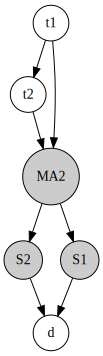

In [3]:
from elfi.examples import ma2
model = ma2.get_model()

elfi.draw(model)

Otherwise everything should be familiar, and ELFI handles everything for you regarding the parallelization. 

In [4]:
rej = elfi.Rejection(model, 'd', batch_size=10000, seed=20170530)

When running the next command, take a look at the system monitor of your operating system; it should show 4 (or whatever number you gave the `ipcluster start` command) Python processes doing heavy computation simultaneously.

In [5]:
%time result = rej.sample(5000, n_sim=int(5e6))  # 5 million simulations

CPU times: user 3.59 s, sys: 417 ms, total: 4 s
Wall time: 20.9 s


The `Sample` object is also just like in the basic case:

In [6]:
result.summary

Method: Rejection
Number of posterior samples: 5000
Number of simulations: 5000000
Threshold: 0.0336
Posterior means: t1: 0.493, t2: 0.0332


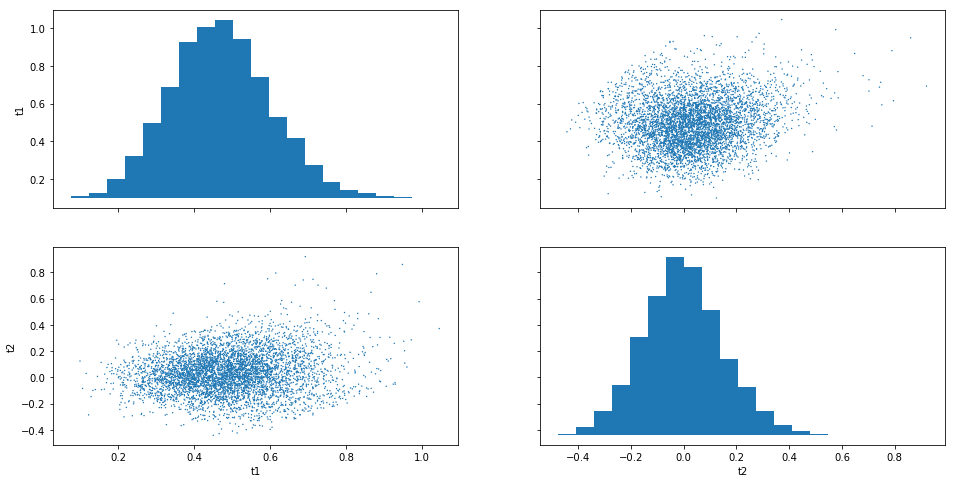

In [7]:
import matplotlib.pyplot as plt
result.plot_pairs()
plt.show()

To summarize, the only thing that needed to be changed from the basic scenario was enabling the `ipyparallel` client.

## Working interactively

All imports and definitions must be visible to all `ipyparallel` engines. You can ensure this by writing a script file that has all the definitions in it. In a distributed setting, this file must be present in all remote workers running an `ipyparallel` engine. 

However, you may wish to experiment in an interactive session, using e.g. a jupyter notebook. `ipyparallel` makes it possible to interactively define functions for ELFI model and send them to workers. This is especially useful if you work from a jupyter notebook. We will show a few examples. More information can be found from [`ipyparallel` documentation](http://ipyparallel.readthedocs.io/). 

In interactive sessions, you can change the model with built-in functionality without problems:

In [8]:
d2 = elfi.Distance('cityblock', model['S1'], model['S2'], p=1)

rej2 = elfi.Rejection(d2, batch_size=10000)
result2 = rej2.sample(1000, quantile=0.01)

But let's say you want to use your very own distance function in a jupyter notebook:

In [9]:
def my_distance(x, y):
    # Note that interactively defined functions must use full module names, e.g. numpy instead of np
    return numpy.sum((x-y)**2, axis=1)

d3 = elfi.Distance(my_distance, model['S1'], model['S2'])
rej3 = elfi.Rejection(d3, batch_size=10000)

This function definition is not automatically visible for the `ipyparallel` engines if it is not defined in a physical file. The engines run in different processes and will not see interactively defined objects and functions. The below would therefore fail:

In [10]:
# This will fail if you try it!
# result3 = rej3.sample(1000, quantile=0.01)

Ipyparallel provides a way to manually `push` the new definition to the scopes of the engines from interactive sessions. Because `my_distance` also uses `numpy`, that must be imported in the engines as well:

In [11]:
# Get the ipyparallel client
ipyclient = elfi.get_client().ipp_client

# Import numpy in the engines (note that you cannot use "as" abbreviations, but must use plain imports)
with ipyclient[:].sync_imports():
    import numpy

# Then push my_distance to the engines
ipyclient[:].push({'my_distance': my_distance});

importing numpy on engine(s)


The above may look a bit cumbersome, but now this works:

In [12]:
rej3.sample(1000, quantile=0.01)  # now this works

Method: Rejection
Number of posterior samples: 1000
Number of simulations: 100000
Threshold: 0.0117
Posterior means: t1: 0.492, t2: 0.0389

However, a simpler solution to cases like this may be to define your functions in external scripts (see `elfi.examples.ma2`) and have the module files be available in the folder where you run your ipyparallel engines.

### Remember to stop the ipcluster when done

In [13]:
!ipcluster stop

2017-06-21 16:06:24.007 [IPClusterStop] Stopping cluster [pid=94248] with [signal=<Signals.SIGINT: 2>]
